In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import random

In [5]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    
    def __add__(self, other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad = other*(self.data**(other - 1))*out.grad
        out._backward = _backward
        return out
   
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad = out.data*out.grad
        out._backward = _backward
        return out

    def relu(self):
        x = self.data
        out = Value(0 if x < 0 else self.data (self, ), 'ReLU')
        def _backward():
            self.grad += (out.data > 0)*out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - (t**2))*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self*(-1)
        
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
     
    def __truediv__(self, other):
        return self*other**-1
        
    def __rtruediv__(self, other):
        return other*self**-1
    
    def __rmul__(self, other):
        return self*other


    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad})'
        

In [6]:
# a = Value(2.0)
# b = Value(3.0)
# g =a/b
# g

# n = a-b
# n

In [7]:
from graphviz import Digraph

def trace(root):
    
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

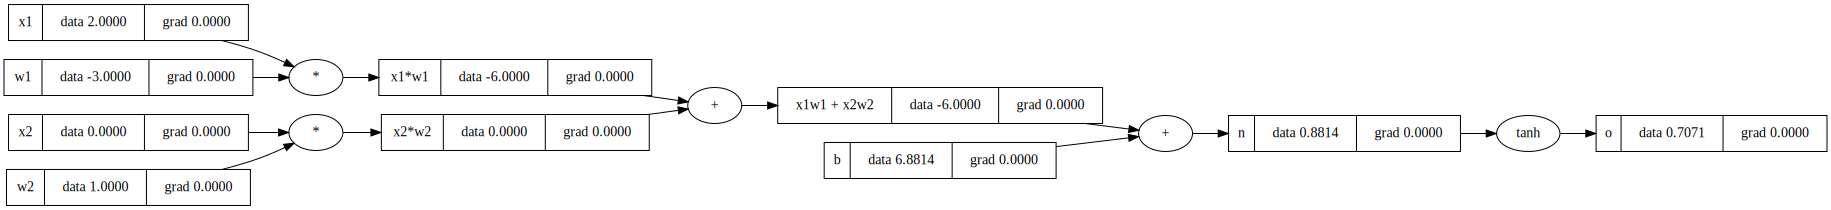

In [8]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

# forward pass

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh(); o.label = 'o'

draw_dot(o)


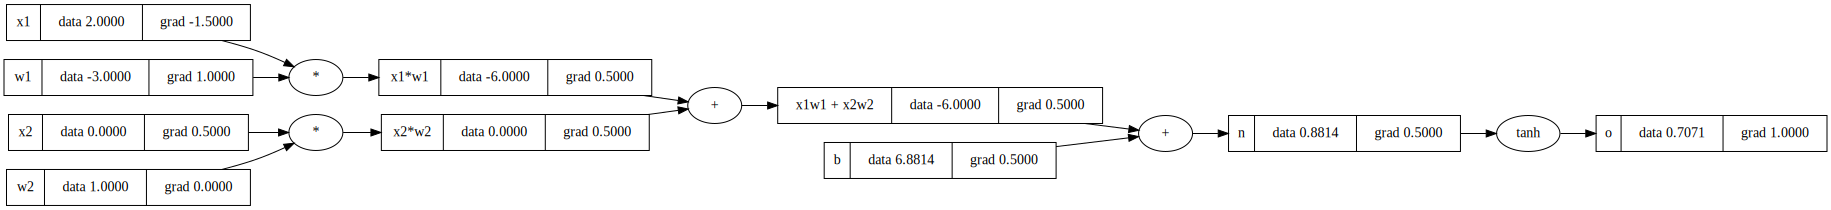

In [9]:
o.backward()
draw_dot(o)

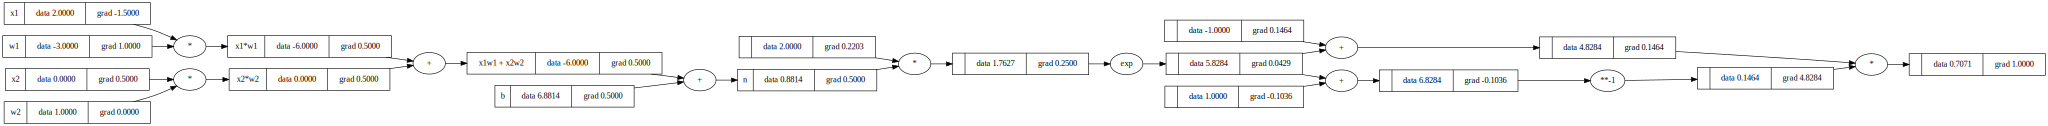

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

# forward pass

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1)/(e+1)
o.backward()
draw_dot(o)

In [11]:
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
                                
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
                                

In [12]:
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

In [13]:
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('b', b.grad.item())

x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0
b 0.5000001283844369


In [25]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def parameters(self):
        return self.w + [self.b]
        
    def __call__(self,x):
        z = sum(wi*xi for wi,xi in zip(self.w, x))
        z = z + self.b
        a = z.tanh()
        return a


class Layer:
    def __init__(self, nin, nout):
       self.neurons = [Neuron(nin) for _ in range(nout)] 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __call__(self, x):
           outs = [n(x) for n in self.neurons]
           return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            

In [26]:
x = [2.0, 3.0, 4.0]
n = MLP(3,[4,4,1])
n(x)
n.layers[0].neurons[0].w[0].grad

0.0

In [27]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-3.0,0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys= [1.0, -1.0, -1.0, 1.0]
for epoch in range(10):
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys, ypred)])
    print(f' loss {loss.data} in number {epoch}')
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    for p in n.parameters():
        p.data+=-0.05*p.grad

ypred = [n(x) for x in xs]
ypred

 loss 3.3366480042699487 in number 0
 loss 2.863370054219318 in number 1
 loss 2.088201435998489 in number 2
 loss 1.3874420672957823 in number 3
 loss 0.9396403656848576 in number 4
 loss 0.6758639972364155 in number 5
 loss 0.5124920459005703 in number 6
 loss 0.4047114804328102 in number 7
 loss 0.32959882312143285 in number 8
 loss 0.2749420530052028 in number 9


[Value(data=0.7712201211001906, grad=0.0),
 Value(data=-0.7818560220884261, grad=0.0),
 Value(data=-0.7014216760514272, grad=0.0),
 Value(data=0.7885814337544955, grad=0.0)]

In [238]:
n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

-0.44582559489437484

In [21]:
draw_dot(loss)


AttributeError: 'str' object has no attribute '_prev'

In [208]:
ypred = n()

[Value(data=0.6627598109589968),
 Value(data=0.7571245500260823),
 Value(data=0.6801260582213052),
 Value(data=0.6221234105396148)]